# Mulitvariate Time Series Forecasting 
Using the Air Quality dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China, I am trying to forecast the pollution level for the next hour.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

**No**: row number

**year**: year of data in this row

**month**: month of data in this row

**day**: day of data in this row

**hour**: hour of data in this row

**pm2.5**: PM2.5 concentration

**DEWP**: Dew Point

**TEMP**: Temperature

**PRES**: Pressure

**cbwd**: Combined wind direction

**Iws**: Cumulated wind speed

**Is**: Cumulated hours of snow

**Ir**: Cumulated hours of rain


In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import datetime as dt
import sklearn.preprocessing as pre
from sklearn import metrics
from matplotlib import pyplot

In [2]:
data = pd.read_csv('/Users/ishitabhandari/Desktop/CS_Resources/pollutionData.csv')
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Consolidating the date and time information into a single date-time so that I can use it as an index later.

In [3]:
data['date_time']= data.apply(lambda x: dt.datetime(x.year, x.month, x.day, x.hour), axis = 1)
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date_time
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [4]:
data['pm2.5'].head(30)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24    129.0
25    148.0
26    159.0
27    181.0
28    138.0
29    109.0
Name: pm2.5, dtype: float64

Missing the first 24 hours of Pollution information, hence removing those and filling the remaining NAs with 0

In [5]:
clean_data = data[24:]
clean_data['pm2.5'].isna().sum()

2043

In [6]:
clean_data['pm2.5'] = clean_data['pm2.5'].fillna(value= 0)

/anaconda3/envs/hello-tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
clean_data['pm2.5'].isna().sum()

0

In [8]:
##Removing all the redundant columns
clean_data.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace= True)
clean_data.head()

/anaconda3/envs/hello-tf/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date_time
24,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
25,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
26,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
27,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
28,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


In [9]:
clean_data.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [34]:
data2 = clean_data.set_index('date_time')

### Prepping the data and Creating an LSTM model 

In [35]:
# convert series to supervised learning
def toSupervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
# load dataset

values = data2.values
# integer encode direction
encoder = pre.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = pre.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = toSupervised(scaled, 1, 1)

In [37]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)',
       'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)'],
      dtype='object')

In [38]:
reframed.drop(reframed.columns[9:], axis=1, inplace=True)
print(reframed.columns)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)'],
      dtype='object')


In [39]:
# split into train and test sets
values = reframed.values
n_train_hours = 3 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


Creating the model

In [40]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

In [41]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 17519 samples
Epoch 1/50
26280/26280 - 3s - loss: 0.0461 - val_loss: 0.0728
Epoch 2/50
26280/26280 - 2s - loss: 0.0167 - val_loss: 0.0214
Epoch 3/50
26280/26280 - 1s - loss: 0.0140 - val_loss: 0.0146
Epoch 4/50
26280/26280 - 1s - loss: 0.0138 - val_loss: 0.0148
Epoch 5/50
26280/26280 - 1s - loss: 0.0138 - val_loss: 0.0152
Epoch 6/50
26280/26280 - 1s - loss: 0.0138 - val_loss: 0.0152
Epoch 7/50
26280/26280 - 1s - loss: 0.0138 - val_loss: 0.0159
Epoch 8/50
26280/26280 - 1s - loss: 0.0138 - val_loss: 0.0157
Epoch 9/50
26280/26280 - 1s - loss: 0.0138 - val_loss: 0.0155
Epoch 10/50
26280/26280 - 1s - loss: 0.0138 - val_loss: 0.0154
Epoch 11/50
26280/26280 - 2s - loss: 0.0137 - val_loss: 0.0157
Epoch 12/50
26280/26280 - 1s - loss: 0.0137 - val_loss: 0.0155
Epoch 13/50
26280/26280 - 1s - loss: 0.0137 - val_loss: 0.0151
Epoch 14/50
26280/26280 - 1s - loss: 0.0137 - val_loss: 0.0150
Epoch 15/50
26280/26280 - 1s - loss: 0.0137 - val_loss: 0.0151
Epoch 16/50
26

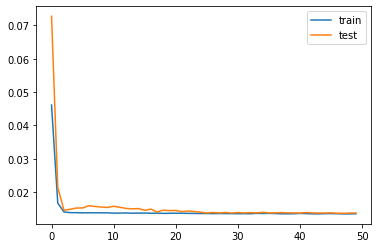

In [42]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The loss sharply drops for test compared to our training set and both the losses approach to 0.


In [43]:
##Predicting pollution
y_pred = model.predict(test_X)

In [44]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((y_pred, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [45]:
# calculate RMSE
rmse = np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.725


The model performance is though above average and but now I am training on a different model with an extra layer.

In [72]:
# split into train and test sets
values = reframed.values
n_train_hours = 3 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


In [73]:
model2 = keras.Sequential()
model2.add(keras.layers.LSTM(84, dropout= 0.025, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(keras.layers.Dense(10))
model2.add(keras.layers.Dense(1))
model2.compile(loss='mae', optimizer='adam')

In [74]:
# fit network
history = model2.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 17519 samples
Epoch 1/50
26280/26280 - 4s - loss: 0.0328 - val_loss: 0.0149
Epoch 2/50
26280/26280 - 2s - loss: 0.0166 - val_loss: 0.0146
Epoch 3/50
26280/26280 - 2s - loss: 0.0163 - val_loss: 0.0151
Epoch 4/50
26280/26280 - 2s - loss: 0.0168 - val_loss: 0.0150
Epoch 5/50
26280/26280 - 1s - loss: 0.0162 - val_loss: 0.0140
Epoch 6/50
26280/26280 - 1s - loss: 0.0162 - val_loss: 0.0143
Epoch 7/50
26280/26280 - 1s - loss: 0.0163 - val_loss: 0.0140
Epoch 8/50
26280/26280 - 2s - loss: 0.0162 - val_loss: 0.0142
Epoch 9/50
26280/26280 - 2s - loss: 0.0160 - val_loss: 0.0139
Epoch 10/50
26280/26280 - 2s - loss: 0.0162 - val_loss: 0.0140
Epoch 11/50
26280/26280 - 1s - loss: 0.0162 - val_loss: 0.0141
Epoch 12/50
26280/26280 - 1s - loss: 0.0161 - val_loss: 0.0144
Epoch 13/50
26280/26280 - 1s - loss: 0.0159 - val_loss: 0.0148
Epoch 14/50
26280/26280 - 2s - loss: 0.0161 - val_loss: 0.0145
Epoch 15/50
26280/26280 - 1s - loss: 0.0158 - val_loss: 0.0149
Epoch 16/50
26

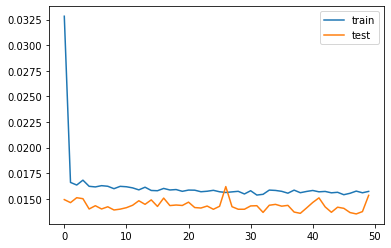

In [75]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [76]:
##Predicting pollution
y_pred = model2.predict(test_X)

In [77]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((y_pred, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [78]:
# calculate RMSE
rmse = np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.375


The RMSE increased slightly and by looking at the plot we can see that the model didn't do well compared to the first one.